In [61]:
from jax import grad,jit,vmap
import jax.numpy as jnp
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel as rbf_kernel_sklearn

In [68]:

def rbf_kernel_jax(X1, X2, gamma=1.0, sigma_f=1.0):
    sqdist = jnp.sum(X1**2, 1).reshape(-1, 1) + jnp.sum(X2**2, 1) - 2 * jnp.dot(X1, X2.T)
    return sigma_f**2 * jnp.exp(-gamma * sqdist)

def rbf_kernel_single(x1, x2, hyperparameters):
    gamma, sigma_f = hyperparameters[0], hyperparameters[1]
    return sigma_f**2 * jnp.exp(-gamma * jnp.sum((x1 - x2)**2))
x = np.array([[1,2,3],[1,3,3]]).reshape(-1,2)
y = np.array([[1,2,3],[1,2,3]]).reshape(-1,2)
print(rbf_kernel_jax(x,y,1,1))
kernel = vmap(vmap(rbf_kernel_single, in_axes=(None, 0, None)), in_axes=(0, None, None))
print(kernel(x,y,[1,1]))

[[1.         0.00673795 0.13533528]
 [0.00673795 1.         0.00673795]
 [0.00673795 0.01831564 0.36787945]]
[[1.         0.00673795 0.13533528]
 [0.00673795 1.         0.00673795]
 [0.00673795 0.01831564 0.36787945]]


now I try to implement the derivatives of the kernel    
I want to do this for the helmholtz equation:  
\begin{align}   
 \mathcal{L}_x ^\omega = \frac{\partial^2}{\partial x^2} - \nu^2 
\end{align}     
The first step would be to use differential operator onto the kernel function twice. So that:
\begin{align}
K_{new}(x,x') = \mathcal{L}_x ^\nu \mathcal{L}_{x'} ^\nu K(x,x')
\end{align}   

\begin{align}   
    \mathcal{L}_x ^\nu \mathcal{L}_{x'} ^\nu k(x, x') = \left(\frac{\partial^2}{\partial x^2} - \nu^2\right)\left(\frac{\partial^2}{\partial x'^2} - \nu^2\right)k(x, x') 
\end{align} 
this then results in:
\begin{align*}
\mathcal{L}\mathcal{L}k(x, x') = & \frac{\partial^4}{\partial x^2 \partial x'^2} k(x, x') - \nu^2 \frac{\partial^2}{\partial x^2} k(x, x') - \nu^2 \frac{\partial^2}{\partial x'^2} k(x, x') + \nu^4 k(x, x')
\end{align*}
Because of the way the rbf works, the two parts with the second derivative can be combined to:
\begin{align*}  
\mathcal{L}\mathcal{L}k(x, x') = & \frac{\partial^4}{\partial x^2 \partial x'^2} k(x, x') - 2\nu^2 \frac{\partial^2}{\partial x^2} k(x, x') + \nu^4 k(x, x')
\end{align*}
To make it more clear, I will call the first part of the result $A$ and the second part $B$, the third part does not need further calculations.

In the following I will try to implement this in code.  
For A we get:
\begin{align*}
A_{ij} = (16{\gamma}^4\cdot\left(x_i-y_j\right)^4-48{\gamma}^3\cdot\left(x_i-y_j\right)^2+12{\gamma}^2)\mathrm{e}^{-{\gamma}\cdot\left(x_i-y_j\right)^2}
\end{align*}
For B we get:
\begin{align*}
B_{ij} = (4{\gamma}^2\cdot\left(x_i-y_j\right)^2-2{\gamma})\mathrm{e}^{-{\gamma}\cdot\left(x_i-y_j\right)^2}
\end{align*}


A has to computed elementwise just like the kernel itself. I will now try to do this once with the expressions and once with autograd.

In [3]:
def A_scratch(x,x_bar, hyperparameters):
    gamma, sigma_f = hyperparameters[0], hyperparameters[1]
    
    kernel_values = rbf_kernel_jax(x, x_bar, gamma,sigma_f)
    #kernel_values = rbf_kernel_jax(x, x_bar, l= 1/np.sqrt(2*gamma), sigma_f_sq = sigma_f**2)

    n, m = x.shape[0], x_bar.shape[0]
    dk_ff = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            dist_sq = (x[i] - x_bar[j])**2
            factor = 16*gamma**4*dist_sq**2 - 48*gamma**3*dist_sq + 12*gamma**2
            dk_ff[i, j] = factor
    return dk_ff * kernel_values
def B_scratch(x,x_bar, hyperparameters):
    gamma, sigma_f = hyperparameters[0], hyperparameters[1]
    nu = hyperparameters[2]
    kernel_values = sigma_f**2*rbf_kernel_sklearn(x, x_bar, gamma)

    n, m = x.shape[0], x_bar.shape[0]
    dk_ff = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            dist_sq = (x[i] - x_bar[j])**2
            factor = 2*nu**2*(4*gamma**2 * dist_sq - 2*gamma)
            dk_ff[i, j] = factor*kernel_values[i,j]
    return dk_ff
def C_scratch(x,x_bar, hyperparameters):
    gamma, sigma_f = hyperparameters[0], hyperparameters[1]
    nu = hyperparameters[2]
    kernel_values = sigma_f**2*rbf_kernel_sklearn(x, x_bar, gamma)

    return nu**4*kernel_values

In [56]:
from jax import vmap, jit
from functools import partial
x = np.array([1.0,2.0,3.0])
y = np.array([1.0,2.0,3.0])
gamma = 1
# @jit
# def rbf_kernel_single(x1, x2, params):
#     gamma, sigma_f = params[0], params[1]
#     return sigma_f**2*jnp.exp(-gamma * jnp.sum((x1 - x2)**2))
def rbf_kernel_single(x1, x2, params):
    gamma, sigma_f = params[0], params[1]
    return sigma_f**2 * jnp.exp(-gamma * jnp.sum((x1 - x2)**2, axis=-1)) # Notice the sum along the last axis


#done with help of https://jejjohnson.github.io/research_notebook/content/notes/kernels/kernel_derivatives.html

def A_autograd(x,x_bar, hyperparameters):
    """only works for 1D arrays atm """

    # Vectorize the kernel function, in_axes specifies which argument is vectorized. I could also use the lambda function for the hyperparameter argument, but this is more readable.
    params_rbf = hyperparameters[:2]
    # first_vmap = vmap(rbf_kernel_single, in_axes=(None, 0, None))
    # vectorized_rbf_kernel = vmap(first_vmap, in_axes=(0, None, None))

    # # Now rbf_kernel should accept 2D arrays for x1 and x2, however atm it only works for 1D arrays
    # K =  vectorized_rbf_kernel(x, x_bar, params_rbf)

    # Now compute the derivatives
    second_derivative_x = grad(grad(rbf_kernel_single, argnums=0), argnums=0)
    fourth_derivative = grad(grad(second_derivative_x, argnums=1), argnums=1)

    # Vectorize the derivative function 
    fourth_derivative_vectorized = vmap(vmap(fourth_derivative, in_axes=(None, 0, None)), in_axes=(0, None, None))

    # Now fourth_derivative_vectorized will accept 2D arrays for x1 and x2
    K_4th_derivative = fourth_derivative_vectorized(x, x_bar, params_rbf)
    return K_4th_derivative 


def A_autograd_2(x,x_bar, hyperparameters):
    """ to check if the autograd function works, however this is very slow in comparison to the other function """
    params_rbf = hyperparameters[:2]
    
    n, m = x.shape[0], x_bar.shape[0]
    dk_ff = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            
            dk_ff[i, j] = grad(grad(grad(grad(rbf_kernel_single, argnums=1), argnums=1), argnums=0), argnums=0)(x[i], x_bar[j], params_rbf)
    return dk_ff


In [82]:
x = np.linspace(0, 10, 100)
x_bar = np.linspace(0, 10, 100)
hyperparameters = [1,1,1]
print(A_autograd(x,x_bar,hyperparameters))
x = np.linspace(0, 10, 100).reshape(-1,1)
x_bar = np.linspace(0, 10, 100).reshape(-1,1)
hyperparameters = [1,1,1]
print(A_scratch(x,x_bar,hyperparameters))


[[12.       11.395061  9.665055 ... -0.       -0.       -0.      ]
 [11.395061 12.       11.395061 ... -0.       -0.       -0.      ]
 [ 9.665055 11.395061 12.       ... -0.       -0.       -0.      ]
 ...
 [-0.       -0.       -0.       ... 12.       11.395058  9.665046]
 [-0.       -0.       -0.       ... 11.395058 12.       11.395058]
 [-0.       -0.       -0.       ...  9.665046 11.395058 12.      ]]
[[12.       11.395061  9.665054 ...  0.        0.        0.      ]
 [11.395061 12.       11.395061 ...  0.        0.        0.      ]
 [ 9.665054 11.395061 12.       ...  0.        0.        0.      ]
 ...
 [ 0.        0.        0.       ... 11.999817 11.395002  9.665153]
 [ 0.        0.        0.       ... 11.395002 12.       11.395177]
 [ 0.        0.        0.       ...  9.665153 11.395177 12.      ]]


Perfect! Both are the same.


In [6]:
def B_autograd(x,x_bar, hyperparameters):
    params_rbf = hyperparameters[:2]
    nu = hyperparameters[2]
    first_vmap = vmap(rbf_kernel_single, in_axes=(None, 0, None))
    vectorized_rbf_kernel = vmap(first_vmap, in_axes=(0, None, None))

    # here we only need the second derivative once with respect to x2
    second_derivative_x2 = grad(grad(rbf_kernel_single, argnums=1), argnums=1)
    second_derivative_x2_vectorized = vmap(vmap(second_derivative_x2, in_axes=(None, 0, None)), in_axes=(0, None, None))
    
    return 2*nu**2*second_derivative_x2_vectorized(x, x_bar, params_rbf)
def C_vectorized(x,x_bar,hyperparameters):
    params_rbf = hyperparameters[:2]
    nu = hyperparameters[2]
    first_vmap = vmap(rbf_kernel_single, in_axes=(None, 0, None))
    vectorized_rbf_kernel = vmap(first_vmap, in_axes=(0, None, None))
    return nu**4*vectorized_rbf_kernel(x, x_bar, params_rbf)
#compare with the scratch function
hyperparameters = [1,3,4]
print("B - comparison")
# print(B_autograd(x_1,y_1,hyperparameters))
# print(B_scratch(x,y,hyperparameters))
print(np.allclose(B_autograd(x_1,y_1,hyperparameters),B_scratch(x,y,hyperparameters)), "B","\n")
print("C - comparison")
# print(C_vectorized(x_1,y_1,hyperparameters))
# print(C_scratch(x,y,hyperparameters))
print(np.allclose(C_vectorized(x_1,y_1,hyperparameters),C_scratch(x,y,hyperparameters)),"C")
    

B - comparison
True B 

C - comparison
True C


Again the same result. So the dimplementation shold be correct.     
Now lets try to implement the kernel with the derivatives.  
At first I want to compute the marginal log likelihood to optimize the hyperparameters $\gamma, \sigma_f$ and the infered hyperparameter from the Helmholtzequation $\nu$.      
The marginal log likelihood is given by:
\begin{align*}
\log p(\mathbf{y} \mid \mathbf{X}, \gamma, \sigma_f, \nu) = & -\frac{1}{2}\mathbf{y}^T\left(K_{new} + \sigma_n^2\mathbf{I}\right)^{-1}\mathbf{y} - \frac{1}{2}\log\left|K_{new} + \sigma_n^2\mathbf{I}\right| - \frac{n}{2}\log 2\pi
\end{align*}

In [7]:
def create_derivative_matrix_scratch(X, X_bar,noise, hyperparameters):
    """ create the derivative matrix with the three functions above """
    A = A_scratch(X, X_bar, hyperparameters)
    B = B_scratch(X, X_bar, hyperparameters)
    C = C_scratch(X, X_bar, hyperparameters)
    return A + B + C 

def create_derivative_matrix_jax(X, X_bar,noise, hyperparameters):
    """ create the derivative matrix with the three functions above """
    A = A_autograd(X, X_bar, hyperparameters)
    B = B_autograd(X, X_bar, hyperparameters)
    C = C_vectorized(X, X_bar, hyperparameters)
    
    return (A + B + C) 

In [8]:
size = 50
x_1, y_1 = np.linspace(0,1,size), np.linspace(0,2,size)
hyperparameters = [1,3,4]
x,y = np.linspace(0,1,size).reshape(-1,1), np.linspace(0,2,size).reshape(-1,1)
np.allclose(create_derivative_matrix_jax(x_1,y_1,0.001,hyperparameters), create_derivative_matrix_scratch(x,y,0.001, hyperparameters))
%timeit create_derivative_matrix_jax(x_1,y_1,0.001,hyperparameters)
%timeit create_derivative_matrix_scratch(x,y,0.001,hyperparameters)

43.6 ms ± 4.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.5 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


For smaller datasets the naive approach is actually faster. But with increasing size of the dataset the autograd approach is extremely more efficient. for n = 50 the speed is nearly the same.It is worth to note that jax is not jet running on the gpu. So the speedup could be even higher.     

Now the next step is to create a dataset and to optimize the hyperparameters. I will just sample some points from the general solution of the one dimensional Helmholtz equation. The general solution is given by:
\begin{align*}
u(x) = A\cdot\mathrm{e}^{i\cdot\nu\cdot x} + B\cdot\mathrm{e}^{-i\cdot\nu\cdot x}
\end{align*}
With simple boundary conditions we get:
\begin{align*}
u(x) = A \cdot sin(\nu x + phi)
\end{align*}
Generally the solution would be an infinite sum of all the different possible wavenumbers. (String fixed between two walls).
I just only use one case n for creating the data.

3.141592653589793 k


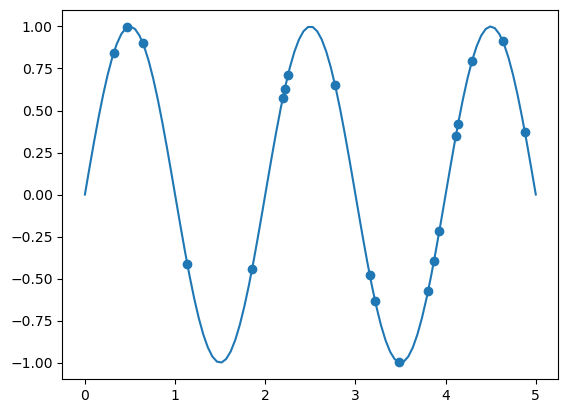

In [13]:
import matplotlib.pyplot as plt
# Parameters
L = 5.0  # Length of the domain
N = 100  # Number of grid points
n = 5     # Mode parameter
A = 1
# Compute the wave number
k = n * np.pi / L
print(k, "k")
n_samples = 20
noise = 0.001
# Compute the analytical solution
def analytical_solution(x,k):
    return A*np.sin(k*x)
rng = np.random.default_rng(seed = 42)
x_train = rng.uniform(0,L,n_samples)
x_train = np.sort(x_train)
targets_train = analytical_solution(x_train,k) + noise*np.random.randn(x_train.size)
x_test = np.linspace(0,L,100)
plt.scatter(x_train, targets_train)
plt.plot(x_test, analytical_solution(x_test, k))

Ok now we have some data. Lets first compute the marginal log likelihood as defined before and then optimize it with respect to the parameters. For some reason the optimization does not work when I compute the K matrix with the jax implementation.

In [35]:
from scipy.optimize import minimize

def log_marginal_likelihood(Kernel:callable, x,targets,data_noise,hyperparams):
    #gamma, sigma_f, nu = hyperparams[0],hyperparams[1],hyperparams[2
    K = create_derivative_matrix_jax(x,x,data_noise,hyperparams) + data_noise * jnp.eye(len(x))
    
    L = jnp.linalg.cholesky(K)
    alpha = jnp.linalg.solve(L.T, np.linalg.solve(L, targets))
    mll = 1/2 * jnp.dot(targets.T,alpha) +0.5*jnp.sum(jnp.log(jnp.diagonal(L))) + len(x)/2 * jnp.log(2*jnp.pi)
    return mll

hyperparameters = [1,1,1]
print(log_marginal_likelihood(create_derivative_matrix_jax,x_train,targets_train,noise,hyperparams=hyperparameters))

def log_marginal_likelihood_to_optimize(Kernel:callable, x,targets,data_noise):
    def function_to_optimize(hyperparams):
        mll = log_marginal_likelihood(Kernel, x,targets,data_noise,hyperparams)
        return mll
    return function_to_optimize

def optimization_restarts(Kernel: callable,n_restarts, X, X_bar, targets, noise):
    
    best_mll = np.inf
    best_theta = np.zeros((3))
    for i in range(n_restarts):
        rng = np.random.default_rng(seed=42)
        theta_initial = rng.uniform(0,4,3)
        res = minimize(log_marginal_likelihood_to_optimize(Kernel, X, targets, noise), x0=theta_initial,
                    method='L-BFGS-B', bounds=((1e-5, None), (1e-5, None), (1e-5, None)))
        if res.fun < best_mll:
            best_mll = res.fun
            best_theta = res.x
    return best_theta

res = optimization_restarts(create_derivative_matrix_jax,5,x_train,x_train,targets_train,noise)
print(res)

10.313433
[3.09582419 1.75551376 3.4343828 ]


Ok now i want to make predictions with the optimized hyperparameters. I will achive this by using the conditional distribution of the gaussian process. The conditional distribution is given by:
\begin{align*}
p(\mathbf{f_*} \mid \mathbf{X_*}, \mathbf{X}, \mathbf{y}) = \mathcal{N}(\mathbf{f_*} \mid \mathbf{K_{**}}\mathbf{K_{xx}}^{-1}\mathbf{y}, \mathbf{K_{**}} - \mathbf{K_{**}}\mathbf{K_{xx}}^{-1}\mathbf{K_{xx}}\mathbf{K_{**}})
\end{align*}

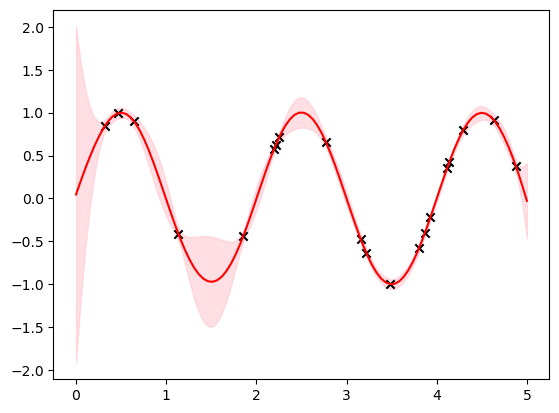

In [37]:
from gaussian_processes_util import plot_gp

def posterior_distribution(Kernel:callable, X, X_bar,noise_data, hyperparams):
    K = create_derivative_matrix_jax(X, X,noise_data,hyperparams) + noise_data * jnp.eye(len(X))
    K_s = create_derivative_matrix_jax(X, X_bar,noise_data,hyperparams)
    K_ss = create_derivative_matrix_jax(X_bar, X_bar,noise_data,hyperparams)
    L = jnp.linalg.cholesky(K)
    alpha = jnp.linalg.solve(L.T, np.linalg.solve(L, targets_train))
    f_star = jnp.dot(K_s.T, alpha)
    v = jnp.linalg.solve(L, K_s)
    var_f_star = K_ss - jnp.dot(v.T, v)
    return f_star, var_f_star
hyperparameters = [1,1.7,3.4]
f_star, var_f_star = posterior_distribution(create_derivative_matrix_jax,x_train,x_test,noise,hyperparams = hyperparameters)
var_plot = jnp.diag(var_f_star)
plt.plot(x_test, f_star, 'r-', label='Predictive mean')

plt.fill_between(x_test, f_star - 2 * jnp.sqrt(var_plot), f_star + 2 * jnp.sqrt(var_plot), color='pink',alpha = 0.5, label='95% confidence interval')
plt.scatter(x_train, targets_train, label='Training data', color='black', marker='x')

C:\Users\Razer\AppData\Local\Temp\ipykernel_10960\1941574565.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu.ravel(), cov, 3)


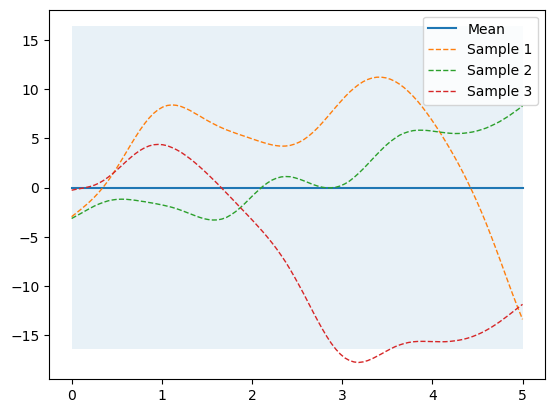

In [12]:
from gaussian_processes_util import plot_gp
hyperparameters = [1,1,np.pi]
mu = np.zeros(x_test.shape)
cov = create_derivative_matrix_jax(x_test, x_test, noise, hyperparameters)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

plot_gp(mu, cov, x_test, samples=samples)